### Importando bibliotecas necessárias

In [6]:
import pandas as pd
import csv

from graph_tool import Graph
import os
from graph_tool import util
import netpixi
import pickle
import warnings
warnings.filterwarnings("ignore")

from regression.integration.gt import *
from netpixi.integration.gt import *

### Dataset NBA players

In [7]:
import pandas as pd
df=pd.read_csv("all_seasons.csv")
df_new=df[['player_name','team_abbreviation','season']]
df_new

,player_name,team_abbreviation,season
0,Dennis Rodman,CHI,1996-97
1,Dwayne Schintzius,LAC,1996-97
2,Earl Cureton,TOR,1996-97
3,Ed O'Bannon,DAL,1996-97
4,Ed Pinckney,MIA,1996-97
...,...,...,...
12300,Markieff Morris,MIA,2021-22
12301,Markelle Fultz,ORL,2021-22
12302,Marcus Smart,BOS,2021-22
12303,Marcus Garrett,MIA,2021-22


### Criação do grafo

In [8]:
from netpixi.integration.gt import Graph

g = Graph(directed=False) # não dirigido

In [9]:
# lista de jogadores
players = df_new['player_name'].unique().tolist()

In [10]:
# adicionar nós para cada jogador
for player in players:
    g.add_vertex(player)

In [11]:
N=3
# filtra os jogadores que jogaram juntos por mais de 2 temporadas
df_filtered = df_new.groupby(['team_abbreviation', 'player_name']).filter(lambda x: x['season'].nunique() > N)

# adiciona as arestas ao grafo
for _, group in df_filtered.groupby(['team_abbreviation', 'season']):
    players = group['player_name'].tolist()
    for i in range(len(players)):
        for j in range(i+1, len(players)):
            # verifica se os jogadores jogaram juntos por mais de 2 temporadas
            num_seasons = len(set(df_new[(df_new['player_name']==players[i]) & (df_new['team_abbreviation']==group['team_abbreviation'].iloc[0])]['season']).intersection(
                                set(df_new[(df_new['player_name']==players[j]) & (df_new['team_abbreviation']==group['team_abbreviation'].iloc[0])]['season'])))
            if num_seasons > N:
                # verifica se a aresta não existe no grafo
                if not g.has_edge(players[i], players[j]):
                    # adiciona a aresta ao grafo
                    g.add_edge(players[i], players[j])
                    e = g.get_edge(players[i], players[j])
                    g.add_ep('seasons_jogadas')
                    e['seasons_jogadas'] = num_seasons
                    


### Análise Exploratória

#### a) Numero de vertices,arestas,densidade

In [12]:
#número de vértices
n = g.num_vertices()
print('O número de vértices é {0}'.format(n))

O número de vértices é 2463


In [13]:
#número de arestas
m = g.num_edges()
print('O número de arestas é {0}'.format(m))

O número de arestas é 1411


In [14]:
##densidade
max_edges = n * (n - 1)
d = m / max_edges
print('A densidade é {0}'.format(round(d,4)))

A densidade é 0.0002


In [15]:
data_targets = pd.DataFrame({k: list(v) for k, v in g.vp.items()})
data_targets.head()

,id
0,Dennis Rodman
1,Dwayne Schintzius
2,Earl Cureton
3,Ed O'Bannon
4,Ed Pinckney


#### B) Estatísticas e histograma do degree. (não é necessário in-degree e out-degree)

In [18]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())

data_targets['degree'] = degrees
data_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2463 non-null   object
 1   degree  2463 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.6+ KB


count    2463.000000
mean        1.145757
std         2.546614
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        23.000000
Name: degree, dtype: float64

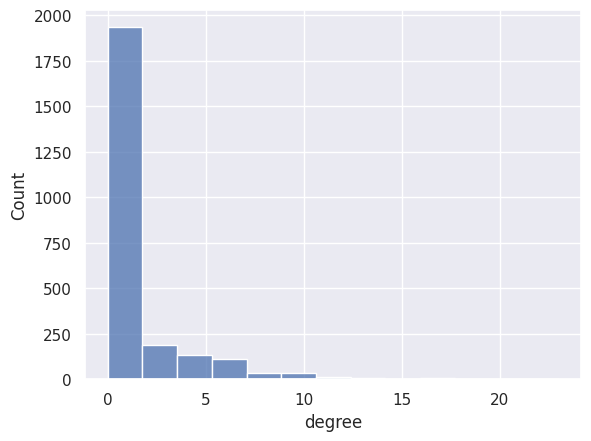

In [19]:
import seaborn as sns
sns.histplot(data_targets['degree'])
data_targets['degree'].describe()

### Análise Visual do Grafo

#### A) Salvando o arquivo

In [20]:
gt_save(g,'Nba_teams.gz')
g = gt_clean(g)

#### B) Visualizando o grafo

In [21]:
g = gt_load('Nba_teams.gz')
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
r=netpixi.render('Nba_teams.gz',infinite=True);

#### C) Ajustando as propriedades visuais do grafo

In [22]:
# mudar a cor de fundo do grafo
r.graph(color=0xdddddd)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0xcccccc, size=10)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=1, curve1=2, curve2=2)

### Regressão linear

In [23]:
#fazer esse drataframe anteriro em menos passos
df_career = df.groupby('player_name').agg({'season': 'nunique', 'net_rating': 'mean', 'draft_number': 'max'}).reset_index()
df_career = df_career.rename(columns={'season': 'num_seasons', 'net_rating': 'career_net_rating'})
#replace dos valores de draft_number para inteiros e "undrafetd" para -1
df_career['draft_number'] = df_career['draft_number'].replace('Undrafted', -1).astype(int)
df_career

,player_name,num_seasons,career_net_rating,draft_number
0,A.C. Green,5,-1.880000,23
1,A.J. Bramlett,1,-32.600000,39
2,A.J. Guyton,3,-6.700000,32
3,AJ Hammons,1,-0.600000,46
4,AJ Price,6,-2.233333,52
...,...,...,...,...
2458,Zion Williamson,2,3.600000,1
2459,Zoran Dragic,1,-15.300000,-1
2460,Zoran Planinic,3,-6.233333,22
2461,Zydrunas Ilgauskas,13,2.107692,20


### Clustering Coefficient

In [24]:
#calculando clustering coefficient:
from graph_tool import clustering

lc = clustering.local_clustering(g)
g.add_vp('clustering', lc)
data_clustering=gt_data(g)

In [25]:
#renomar a coluna clustering para clustering_coefficient e acrescentar a coluna player_name e o id virar numero
data_clustering=data_clustering.reset_index().rename(columns={'id': 'player_name'})
data_clustering

,player_name,clustering
0,Dennis Rodman,0.0
1,Dwayne Schintzius,0.0
2,Earl Cureton,0.0
3,Ed O'Bannon,0.0
4,Ed Pinckney,0.0
...,...,...
2458,McKinley Wright IV,0.0
2459,Matt Ryan,0.0
2460,Marko Simonovic,0.0
2461,Marcus Garrett,0.0


In [26]:
lista_clustering=[]
for value in data_clustering['clustering']:
    lista_clustering.append(value)
df_career['clustering']=lista_clustering
df_career


,player_name,num_seasons,career_net_rating,draft_number,clustering
0,A.C. Green,5,-1.880000,23,0.0
1,A.J. Bramlett,1,-32.600000,39,0.0
2,A.J. Guyton,3,-6.700000,32,0.0
3,AJ Hammons,1,-0.600000,46,0.0
4,AJ Price,6,-2.233333,52,0.0
...,...,...,...,...,...
2458,Zion Williamson,2,3.600000,1,0.0
2459,Zoran Dragic,1,-15.300000,-1,0.0
2460,Zoran Planinic,3,-6.233333,22,0.0
2461,Zydrunas Ilgauskas,13,2.107692,20,0.0


### Regressão Linear

In [27]:
##Análise sem importar o clustering

### Experiência vs potencial

In [28]:
import regression as reg

from scipy import stats

result=reg.linear(data=df_career,formula=' num_seasons~draft_number')


In [29]:
result.micro_summary()

variable,coefficient,std error,p-value
draft_number,-0.006983,0.004316,0.105777


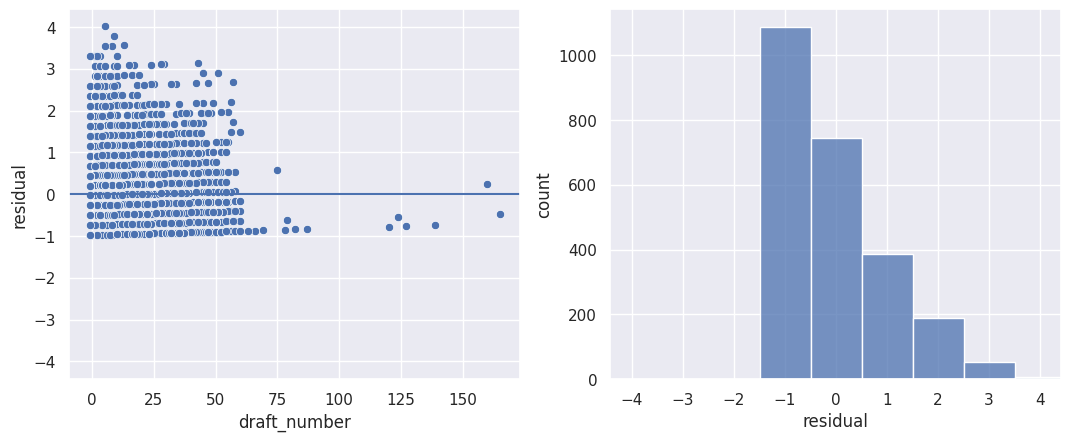

In [30]:
result.plot_residuals(df_career['draft_number'])

### Experiência vs Impacto

In [31]:
import regression as reg

from scipy import stats

result=reg.linear(data=df_career,formula=' num_seasons~career_net_rating')

In [32]:
result.micro_summary()

variable,coefficient,std error,p-value
career_net_rating,0.054992,0.005447,0.000000


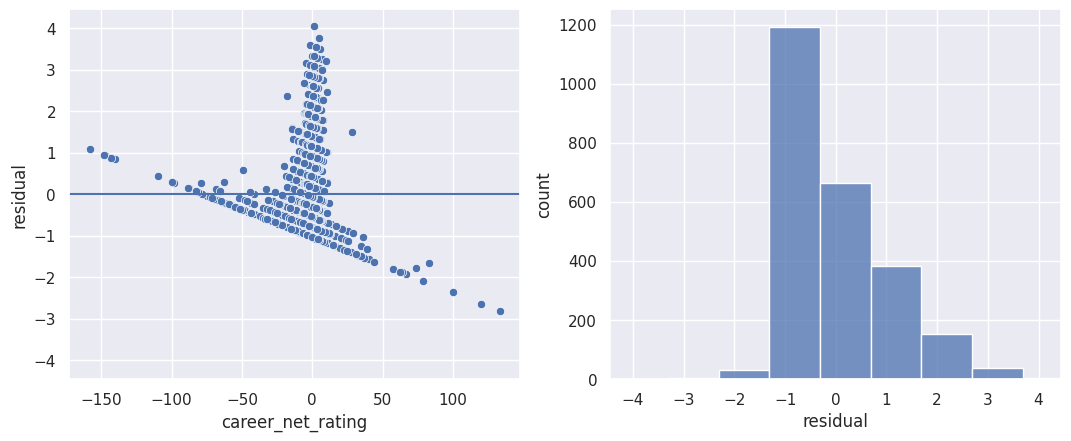

In [33]:
result.plot_residuals(df_career['career_net_rating'])

### Experiência vs adaptabilidade

In [34]:
import regression as reg

from scipy import stats

result=reg.linear(data=df_career,formula=' num_seasons~clustering')

In [35]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.342801,0.256788,0.182014


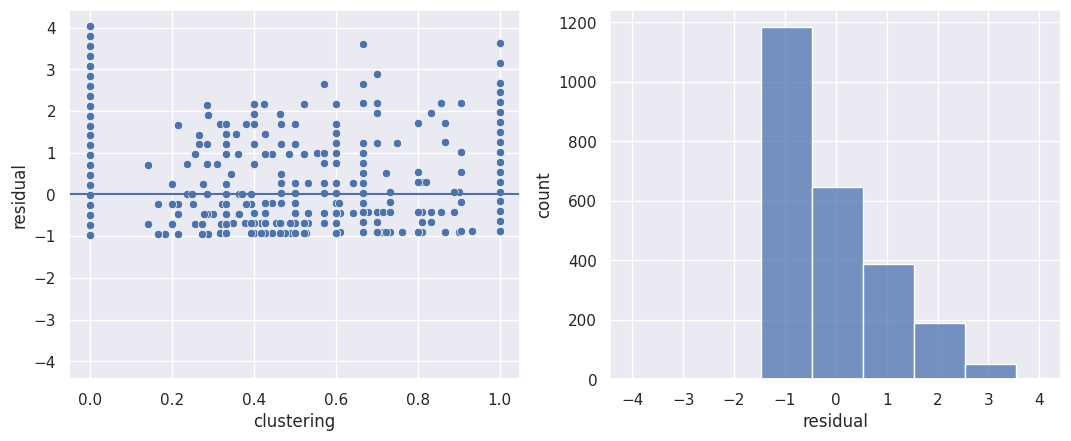

In [36]:
result.plot_residuals(df_career['clustering'])

### Análise Multivariada

In [37]:
result=reg.linear(data=df_career,formula=' num_seasons~draft_number+career_net_rating+clustering')
result.micro_summary()

variable,coefficient,std error,p-value
draft_number,-0.006143,0.004230,0.146548
career_net_rating,0.055123,0.005448,0.000000
clustering,-0.428473,0.251711,0.088837


### Gráficos de Residuos


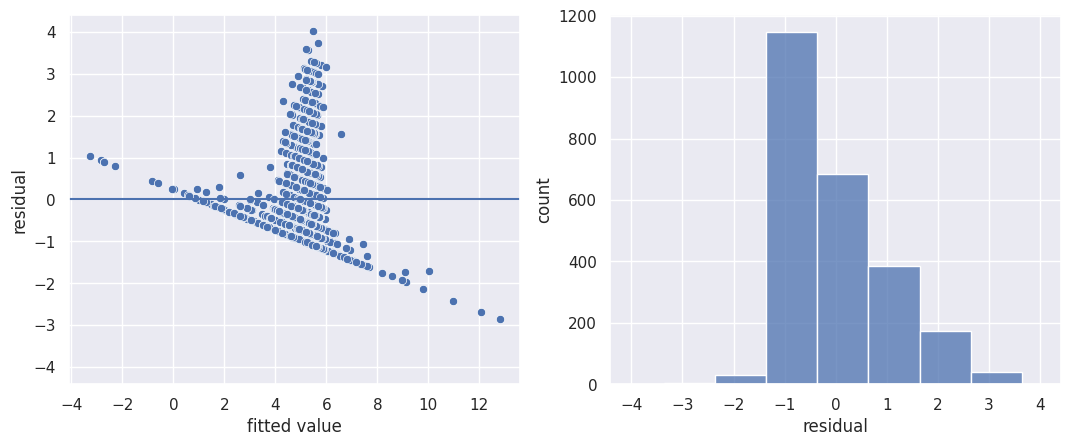

In [38]:
result.plot_residuals()